In [3]:
import sys
#sys.path
sys.path.append('../')

In [4]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data
import exponential_modeling

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

## get prediction for next day

There are currently two models:   
  1. method="exponential" fits an exponential curve to the number of deaths  
  2. method="cases_exponential_rate_constant" fits an exponential curve to the number of cases, and use the death rate of the previous day to estimate deaths  

In [7]:
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [8]:
df = exponential_modeling.estimate_deaths(df)

In [9]:
df['predicted_deaths_exponential']

826     293
1278    117
501      35
842      14
1288     16
       ... 
488       0
485       0
484       0
483       0
1345      0
Name: predicted_deaths_exponential, Length: 1346, dtype: int64

## Validation (for counties with more than 5 deaths)

In [10]:
df2 = exponential_modeling.create_leave_one_day_out_valid(df)
method = 'cases_exponential_rate_constant'
df2 = exponential_modeling.estimate_deaths(df2, method=method)

In [11]:
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
preds = df2[f'predicted_deaths_{method}']

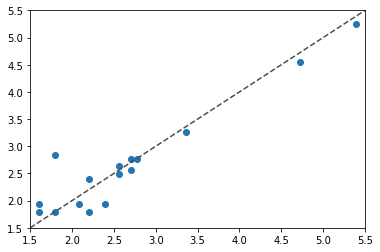

In [12]:
plt.scatter(np.log(preds[outcome > 5]), np.log(outcome[outcome > 5]))
plt.xlim([1.5, 5.5])
plt.ylim([1.5, 5.5])
plt.plot([1.5, 5.5], [1.5, 5.5], ls="--", c=".3")